# **[ExE]Bank Investimentos: Modeling**

> **Campanha de marketing otimizada**: a campanha anual para a adesão ao depósito a prazo fixo impacta milhões de possíveis clientes, mas tem uma taxa de conversão modesta de 13%
>> **Objetivo**: melhorar os resultados da campanha aumentando a taxa de conversão e reduzir custo.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from imblearn.pipeline import Pipeline
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import plot_confusion_matrix

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## **Features and targets**

In [4]:
infobank_df = pd.read_csv('database_clean.csv')
infobank_df

,age,job,marital,education,default,housing,loan,contact,trimestre,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,others,0,1,0,0,0,0,1,0,...,1,3,0,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,others,0,2,1,0,0,0,1,0,...,1,3,0,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,others,0,2,0,1,0,0,1,0,...,1,3,0,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,0,1,0,0,0,0,1,0,...,1,3,0,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,others,0,2,0,0,1,0,1,0,...,1,3,0,0,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41161,73,retired,0,3,0,1,0,1,3,4,...,1,3,0,0,-1.1,94.767,-50.8,1.028,4963.6,1
41162,46,others,0,3,0,0,0,1,3,4,...,1,3,0,0,-1.1,94.767,-50.8,1.028,4963.6,0
41163,56,retired,0,4,0,1,0,1,3,4,...,2,3,0,0,-1.1,94.767,-50.8,1.028,4963.6,0
41164,44,others,0,3,0,0,0,1,3,4,...,1,3,0,0,-1.1,94.767,-50.8,1.028,4963.6,1


In [5]:
X_sample = infobank_df.drop(['duration', 'y', ], axis=1, inplace=False)
Y_sample = infobank_df['y']

In [6]:
ii = X_sample.duplicated()
X_sample = X_sample[~ii]
Y_sample = Y_sample[~ii]

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_sample, Y_sample, test_size=0.3, stratify=Y_sample, random_state=0)

## **Reweighting**

In [8]:
weights = [{0:x, 1:1-x} for x in np.linspace(0.05, 0.95, num=20)]

In [9]:
pip_LogR = Pipeline([
    ('ohe', OneHotEncoder(use_cat_names=True)),
    ('scaler', StandardScaler()),
    ('resample', RandomOverSampler()),
    ('estimator', LogisticRegression(penalty='l2', max_iter=200, solver='lbfgs', class_weight=None,
                                     n_jobs=-1, random_state=0))
])

In [10]:
param_LogR = dict(estimator__penalty=['l1', 'l2'],
                  estimator__solver = ['newton-cg', 'lbfgs'],
                  estimator__class_weight = weights)

### **Recall**

In [11]:
grid_LogR = GridSearchCV(pip_LogR, param_grid=param_LogR, cv=3, scoring='recall', n_jobs=-1)
grid_LogR.fit(X_train, Y_train)

print("Logistic Regression")
print("Mean cross-validated score of the best_estimator: %.3f" % grid_LogR.best_score_)
print("The best parameters:", grid_LogR.best_params_)

Logistic Regression
Mean cross-validated score of the best_estimator: 1.000
The best parameters: {'estimator__class_weight': {0: 0.05, 1: 0.95}, 'estimator__penalty': 'l2', 'estimator__solver': 'newton-cg'}


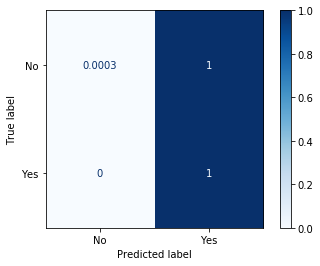

In [12]:
labels_display = ['No', 'Yes']
plot_confusion_matrix(grid_LogR.best_estimator_, X_test, Y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='true')

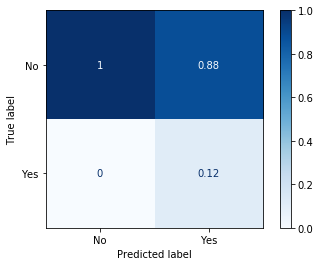

In [13]:
plot_confusion_matrix(grid_LogR.best_estimator_, X_test, Y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='pred')

### **Precision**

In [14]:
grid_LogR = GridSearchCV(pip_LogR, param_grid=param_LogR, cv=3, scoring='precision', n_jobs=-1)
grid_LogR.fit(X_train, Y_train)

print("Logistic Regression")
print("Mean cross-validated score of the best_estimator: %.3f" % grid_LogR.best_score_)
print("The best parameters:", grid_LogR.best_params_)

Logistic Regression
Mean cross-validated score of the best_estimator: 0.773
The best parameters: {'estimator__class_weight': {0: 0.95, 1: 0.050000000000000044}, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


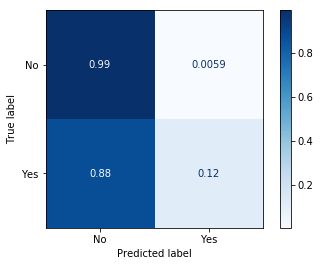

In [15]:
plot_confusion_matrix(grid_LogR.best_estimator_, X_test, Y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='true')

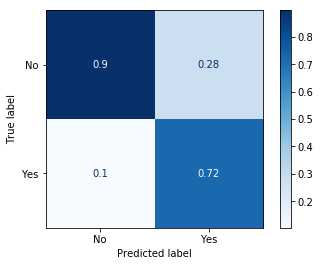

In [16]:
plot_confusion_matrix(grid_LogR.best_estimator_, X_test, Y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='pred')

## **Balanced accuracy**

In [17]:
grid_LogR = GridSearchCV(pip_LogR, param_grid=param_LogR, cv=3, scoring='balanced_accuracy', n_jobs=-1)
grid_LogR.fit(X_train, Y_train)

print("Logistic Regression")
print("Mean cross-validated score of the best_estimator: %.3f" % grid_LogR.best_score_)
print("The best parameters:", grid_LogR.best_params_)

Logistic Regression
Mean cross-validated score of the best_estimator: 0.738
The best parameters: {'estimator__class_weight': {0: 0.5236842105263158, 1: 0.47631578947368425}, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


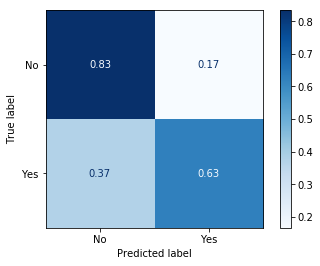

In [18]:
plot_confusion_matrix(grid_LogR.best_estimator_, X_test, Y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='true')

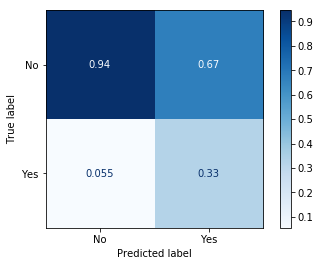

In [19]:
plot_confusion_matrix(grid_LogR.best_estimator_, X_test, Y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='pred')

## **F1 score**

In [20]:
grid_LogR = GridSearchCV(pip_LogR, param_grid=param_LogR, cv=3, scoring='f1', n_jobs=-1)
grid_LogR.fit(X_train, Y_train)

print("Logistic Regression")
print("Mean cross-validated score of the best_estimator: %.3f" % grid_LogR.best_score_)
print("The best parameters:", grid_LogR.best_params_)

/home/anderson/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Logistic Regression
Mean cross-validated score of the best_estimator: 0.482
The best parameters: {'estimator__class_weight': {0: 0.618421052631579, 1: 0.381578947368421}, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


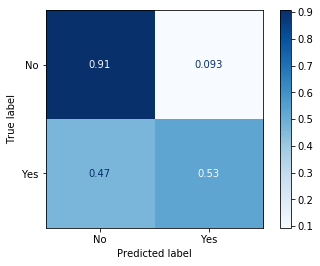

In [21]:
plot_confusion_matrix(grid_LogR.best_estimator_, X_test, Y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='true')

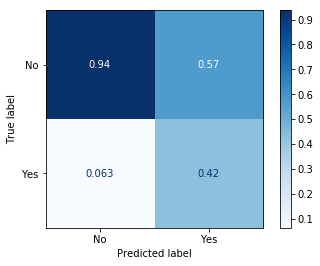

In [22]:
plot_confusion_matrix(grid_LogR.best_estimator_, X_test, Y_test, display_labels=labels_display, 
                    cmap=plt.cm.Blues, normalize='pred')